# **Weighted Influence Score**

Not all interactions are equal since comparatively Comments are more influential than Likes which are more influential than Views (in terms of viewer effort)

We weighed them as such:

1.   View = 1
2.   Like = 3



1.   Comment = 5







In [ ]:
!pip install -qq bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 3.0 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from typing import List, Dict
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import re

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [ ]:
# Load the CSV file
df = pd.read_csv("october_videos.csv")

# Preview the first 5 rows
print(df.head())

    Channel     Video ID                                              Title  \
0  ABC News  QWhBHJfVaN0  SNAP benefits set to run out due to government...   
1  ABC News  pHIbuFQapLc            The history behind daylight saving time   
2  ABC News  fOU8qXMoUaw  Blood visible from space in Sudan shows eviden...   
3  ABC News  LnxWSjNeC4s  Blood visible from space in Sudan shows eviden...   
4  ABC News  NbwWV1yA--E  Judge rules Trump's attempt to suspend SNAP fu...   

              Published   Views  Likes  Comments Duration  
0  2025-10-31T23:00:40Z   52945    744       243    PT42S  
1  2025-10-31T21:26:21Z   27091    260         7   PT1M3S  
2  2025-10-31T20:59:30Z  158978   2477       179  PT2M15S  
3  2025-10-31T19:04:45Z   77483    511       343  PT3M19S  
4  2025-10-31T18:34:49Z  674022   1788      2006  PT1M19S  


In [ ]:
# Create the Influence column
df["Influence"] = (3 * df["Likes"] * 5 * df["Comments"]) * df["Views"]

# Preview the result
print(df.head())

    Channel     Video ID                                              Title  \
0  ABC News  QWhBHJfVaN0  SNAP benefits set to run out due to government...   
1  ABC News  pHIbuFQapLc            The history behind daylight saving time   
2  ABC News  fOU8qXMoUaw  Blood visible from space in Sudan shows eviden...   
3  ABC News  LnxWSjNeC4s  Blood visible from space in Sudan shows eviden...   
4  ABC News  NbwWV1yA--E  Judge rules Trump's attempt to suspend SNAP fu...   

              Published   Views  Likes  Comments Duration       Influence  
0  2025-10-31T23:00:40Z   52945    744       243    PT42S    143580486600  
1  2025-10-31T21:26:21Z   27091    260         7   PT1M3S       739584300  
2  2025-10-31T20:59:30Z  158978   2477       179  PT2M15S   1057322138610  
3  2025-10-31T19:04:45Z   77483    511       343  PT3M19S    203710167885  
4  2025-10-31T18:34:49Z  674022   1788      2006  PT1M19S  36263003700240  


In [ ]:
# Scale the influence
df["Influence_scaled"] = np.log1p((3 * df["Likes"] * 5 * df["Comments"]) * df["Views"])

In [ ]:
# Rank videos from most to least influential
df_ranked = df.sort_values(by="Influence_scaled", ascending=False)

# View the top rows
print(df_ranked.head())

                     Channel     Video ID  \
705  The Wall Street Journal  f3c4mQty_so   
760       The New York Times  xLf1EneAyLQ   
766       The New York Times  _UO6LCIAknw   
588          The Young Turks  pj0IJLzKUdw   
792       The New York Times  02fbxkl0UgQ   

                                                 Title             Published  \
705  I Tried the First Humanoid Home Robot. It Got ...  2025-10-28T18:00:38Z   
760              How the Louvre Jewelry Heist Unfolded  2025-10-21T22:15:07Z   
766              What Went Wrong With This Skyscraper?  2025-10-20T16:01:07Z   
588  ICE Slapped With $50M Lawsuit For Throwing 79 ...  2025-10-20T20:00:41Z   
792  How Portland Is Reacting to Trump’s National G...  2025-10-09T12:30:00Z   

       Views  Likes  Comments Duration         Influence  Influence_scaled  
705  1886482  31304      5734  PT9M15S  5079271741733280         36.163944  
760  1823453  49148      2965   PT2M5S  3985808051256900         35.921516  
766  1856052  606

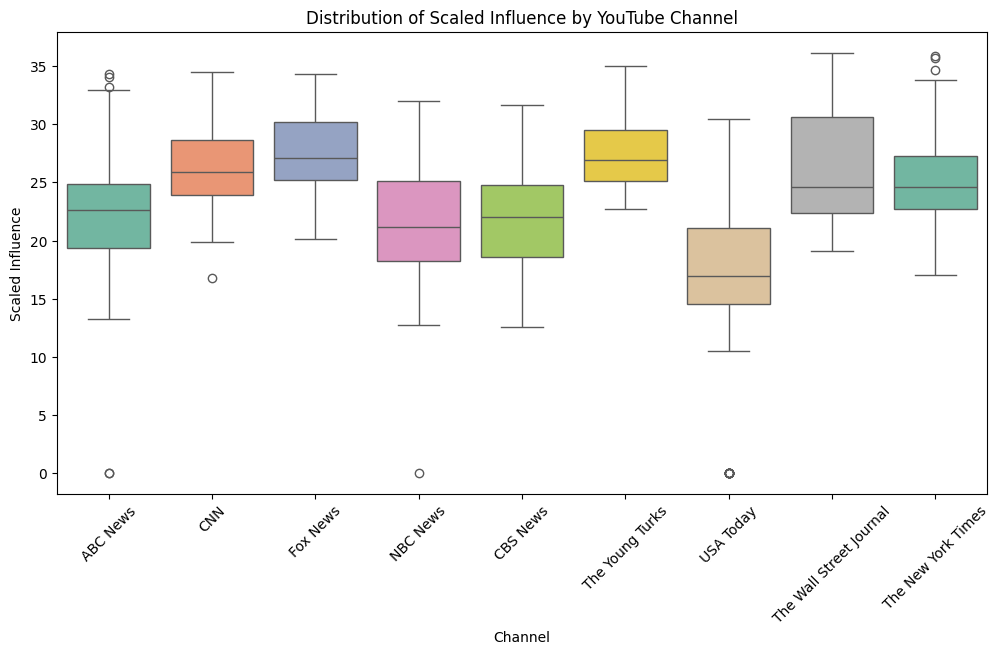

In [ ]:
plt.figure(figsize=(12,6))

# Boxplot with different colors for each channel
sns.boxplot(
    x="Channel",
    y="Influence_scaled",
    data=df,
    palette="Set2"  # for trying "tab10", "Paired", or a custom list of colors
)

plt.xticks(rotation=45)
plt.title("Distribution of Scaled Influence by YouTube Channel")
plt.ylabel("Scaled Influence")
plt.xlabel("Channel")
plt.show()

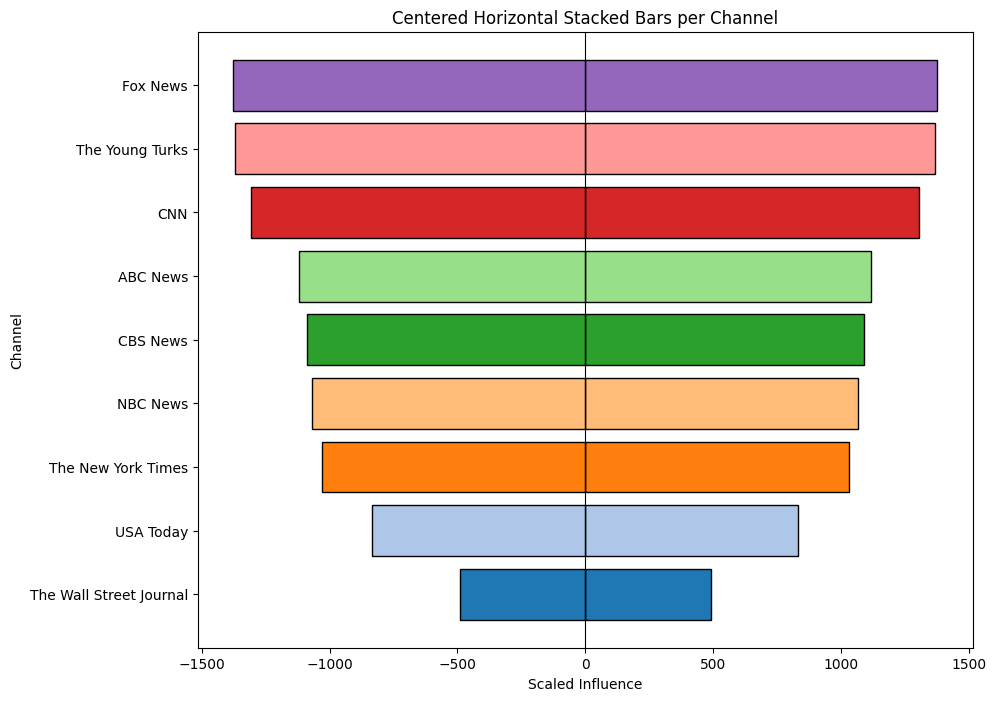

In [ ]:
# Aggregate scaled influence per channel
channel_influence = df.groupby("Channel")["Influence_scaled"].sum().sort_values()

# Split influence around central axis
half_total = channel_influence / 2
neg_half = -half_total  # left side
pos_half = half_total   # right side

# Plot horizontal centered bars
plt.figure(figsize=(10,8))
plt.barh(channel_influence.index, pos_half, color=plt.cm.tab20.colors, edgecolor='black')
plt.barh(channel_influence.index, neg_half, color=plt.cm.tab20.colors, edgecolor='black')

plt.axvline(0, color='black', linewidth=0.8)  # central axis
plt.xlabel("Scaled Influence")
plt.ylabel("Channel")
plt.title("Centered Horizontal Stacked Bars per Channel")
plt.show()

# **Duration Analysis**

In [ ]:
def parse_youtube_duration(duration_str):
    pattern = r'PT(?:(\d+)H)?(?:(\d+)M)?(?:(\d+)S)?'
    hours, minutes, seconds = re.match(pattern, duration_str).groups()
    hours = int(hours) if hours else 0
    minutes = int(minutes) if minutes else 0
    seconds = int(seconds) if seconds else 0
    return hours * 3600 + minutes * 60 + seconds


In [ ]:
df["Duration_seconds"] = df["Duration"].apply(parse_youtube_duration)
df["Duration_minutes"] = df["Duration_seconds"] / 60

/tmp/ipython-input-126170123.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(


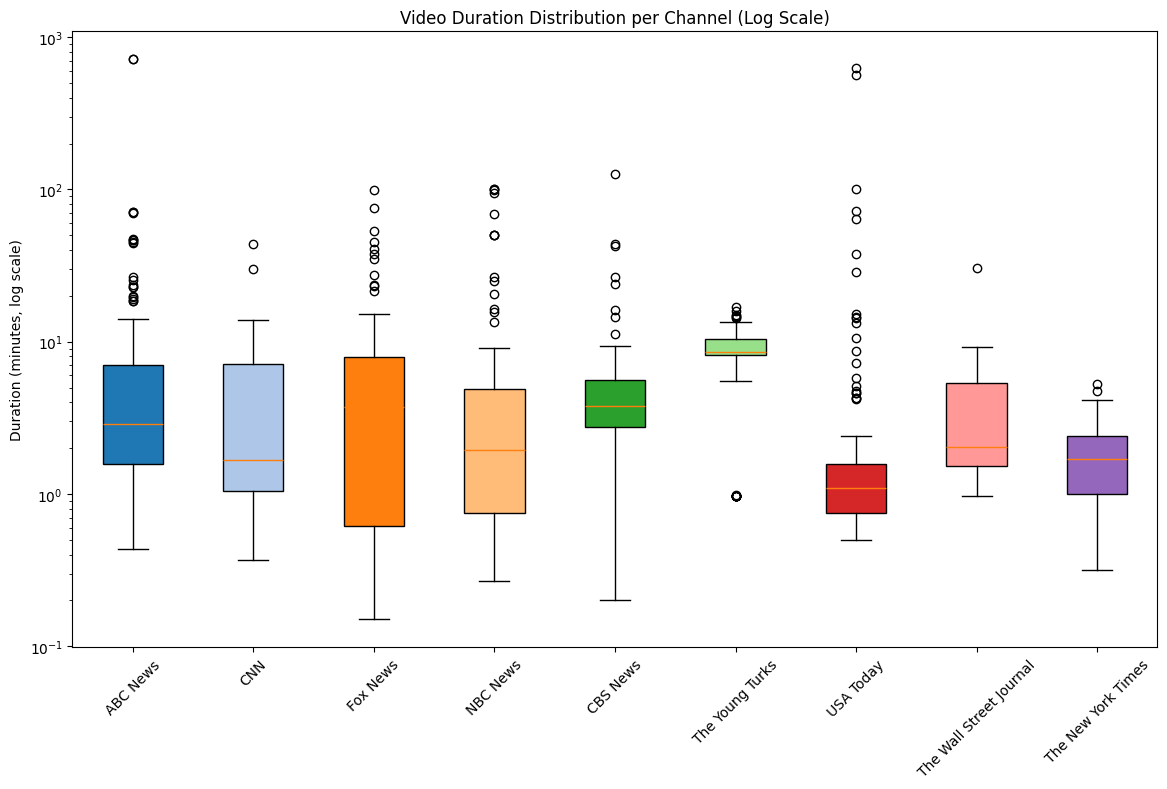

In [ ]:
channels_sorted = df['Channel'].unique()
data = [df[df['Channel'] == channel]['Duration_minutes'].values
        for channel in channels_sorted]

plt.figure(figsize=(14, 8))
box = plt.boxplot(
    data,
    vert=True,
    patch_artist=True,
    labels=channels_sorted
)

# Colors
for patch, color in zip(box['boxes'], plt.cm.tab20.colors):
    patch.set_facecolor(color)

plt.yscale("log")
plt.ylabel("Duration (minutes, log scale)")
plt.title("Video Duration Distribution per Channel (Log Scale)")
plt.xticks(rotation=45)
plt.show()

# **Thematic Analysis**

In [ ]:
# Optional: Clean titles
df["Title"] = df["Title"].astype(str).str.strip()

# Load embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# A dictionary to store topic results per channel
channel_topics = {}

# Loop through channels
for channel in df["Channel"].unique():

    print(f"\n--- Processing Channel: {channel} ---")

    # Filter video titles for this channel
    titles = df[df["Channel"] == channel]["Title"].tolist()

    # Skip if too few titles
    if len(titles) < 10:
        print(f"Not enough data for {channel}, skipping.")
        continue

    # Create a topic model
    topic_model = BERTopic(embedding_model=embedding_model,
                           min_topic_size=3,  # more granular, niche topics but may create less stable topics
                           verbose=False)

    topics, probs = topic_model.fit_transform(titles)

    # Save results
    channel_topics[channel] = {
        "model": topic_model,
        "titles": titles,
        "topics": topics,
        "probs": probs,
        "topic_info": topic_model.get_topic_info()
    }

    # Show summary for this channel
    print(topic_model.get_topic_info().head())

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


--- Processing Channel: ABC News ---
   Topic  Count                      Name  \
0     -1      6     -1_ice_and_with_actor   
1      0     18   0_2025_october_abc_news   
2      1     16      1_in_of_massey_sonya   
3      2     15  2_benefits_snap_set_food   
4      3     13       3_trump_to_china_xi   

                                      Representation  \
0  [ice, and, with, actor, attacks, congressional...   
1  [2025, october, abc, news, broadcast, full, 29...   
2  [in, of, massey, sonya, sudan, guilty, from, e...   
3  [benefits, snap, set, food, to, as, for, milli...   
4  [trump, to, china, xi, nuclear, meeting, penta...   

                                 Representative_Docs  
0  [Progressive congressional candidate indicted ...  
1  [Good Morning America Full Broadcast —  Wednes...  
2  [Jury finds ex-deputy guilty of murder in Sony...  
3  [Government shutdown triggers food crisis for ...  
4  [Trump directs Pentagon to match Russia, China...  

--- Processing Channel:

In [ ]:
all_topics = []

for channel, data in channel_topics.items():
    info = data["topic_info"]
    info["Channel"] = channel
    all_topics.append(info)

final_df = pd.concat(all_topics)
final_df.to_csv("channel_themes.csv", index=False)

In [ ]:
dominant_topics = (
    final_df.groupby(["Channel", "Topic"])
    .agg({"Count": "sum"})
    .reset_index()
)

# largest count = dominant theme
dominant_per_channel = (
    dominant_topics.sort_values(["Channel", "Count"], ascending=[True, False])
    .groupby("Channel")
    .head(1)
)

In [ ]:
print(dominant_per_channel)

                    Channel  Topic  Count
1                  ABC News      0     18
11                 CBS News      0     20
20                      CNN      0     31
27                 Fox News     -1     22
39                 NBC News      0     17
51       The New York Times      0     12
62  The Wall Street Journal      0     13
65          The Young Turks      0     85
68                USA Today      0     24


In [ ]:
for channel, data in channel_topics.items():
    topic_id = dominant_per_channel.loc[dominant_per_channel["Channel"] == channel, "Topic"].values[0]

    print(f"\nChannel: {channel}")

    if topic_id == -1:
        print("Dominant topic is -1 (outlier/no clear theme).")
    else:
        # Get the keywords of the topic
        keywords = data["model"].get_topic(topic_id)
        # keywords is a list of (word, score) tuples
        keyword_list = [word for word, score in keywords]
        print("Dominant topic keywords:", ", ".join(keyword_list))


Channel: ABC News
Dominant topic keywords: 2025, october, abc, news, broadcast, full, 29, live, 30, america

Channel: CNN
Dominant topic keywords: shutdown, trump, food, to, snap, on, in, governor, federal, filibuster

Channel: Fox News
Dominant topic is -1 (outlier/no clear theme).

Channel: NBC News
Dominant topic keywords: melissa, hurricane, after, flooding, with, at, severe, stranded, dog, firefighters

Channel: CBS News
Dominant topic keywords: shutdown, snap, government, benefits, to, republicans, funding, lapse, as, are

Channel: The Young Turks
Dominant topic keywords: trump, as, the, in, fox, johnson, on, maga, gets, his

Channel: USA Today
Dominant topic keywords: hurricane, melissa, jamaica, in, storm, aftermath, as, of, cuba, flooding

Channel: The Wall Street Journal
Dominant topic keywords: shutdown, day, government, to, of, this, what, how, democrats, affects

Channel: The New York Times
Dominant topic keywords: nyc, by, melissa, philippines, hits, hurricane, hit, dead

**ABC News** - General News / Mixed Coverage

**CNN** - Disaster / Weather / Humanitarian Coverage

**Fox News** - Mixed / Varied Coverage

**NBC News** - Disaster / Weather / Humanitarian Coverage

**CBS News** - Politics / Government Coverage

**The Young Turks** - Politics / US Politics

**USA Today** - Politics / Government & International Affairs

**The Wall Street Journal** - Politics / Government / Policy

**The New York Times** - Mixed / Varied Coverage



# **Sentiment Analysis**

In [ ]:
class YouTubeSentimentAnalyzer:
    """
    Sentiment analyzer for YouTube video titles using fine-tuned BERT models
    """

    def __init__(self, model_name: str = "cardiffnlp/twitter-roberta-base-sentiment-latest"):
        """
        Initialize the sentiment analyzer

        Args:
            model_name: HuggingFace model identifier
                       Options:
                       - "cardiffnlp/twitter-roberta-base-sentiment-latest" (Recommended)
                       - "distilbert-base-uncased-finetuned-sst-2-english"
                       - "nlptown/bert-base-multilingual-uncased-sentiment"
        """
        print(f"Loading model: {model_name}")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

        # Label mapping (adjust based on your model)
        self.label_map = {
            0: "NEGATIVE",
            1: "NEUTRAL",
            2: "POSITIVE"
        }

    def analyze_batch(self, titles: List[str], batch_size: int = 16) -> List[Dict]:
        """
        Analyze sentiment of multiple titles efficiently

        Args:
            titles: List of YouTube video titles
            batch_size: Number of titles to process at once

        Returns:
            List of dictionaries with sentiment analysis results
        """
        results = []

        for i in range(0, len(titles), batch_size):
            batch = titles[i:i + batch_size]

            # Tokenize batch
            inputs = self.tokenizer(
                batch,
                return_tensors="pt",
                truncation=True,
                max_length=512,
                padding=True
            ).to(self.device)

            # Get predictions
            with torch.no_grad():
                outputs = self.model(**inputs)
                logits = outputs.logits

            # Calculate probabilities
            probabilities = torch.nn.functional.softmax(logits, dim=-1)
            confidences, predicted_classes = torch.max(probabilities, dim=1)

            # Process each result in batch
            for j, title in enumerate(batch):
                all_scores = {
                    self.label_map[k]: probabilities[j][k].item()
                    for k in range(len(self.label_map))
                }

                results.append({
                    "title": title,
                    "label": self.label_map[predicted_classes[j].item()],
                    "confidence": confidences[j].item(),
                    "scores": all_scores
                })

        return results

    def analyze_from_dataframe(self, df: pd.DataFrame, title_column: str = "Title") -> pd.DataFrame:
      """
      Analyze sentiments from a DataFrame containing YouTube titles

      Args:
          df: DataFrame with video titles
          title_column: Name of column containing titles

      Returns:
          DataFrame with original data plus sentiment analysis results
      """
      # Check if column exists
      if title_column not in df.columns:
          raise ValueError(f"Column '{title_column}' not found in DataFrame. Available columns: {df.columns.tolist()}")

      print(f"Analyzing {len(df)} titles...")

      # Create a copy to avoid modifying original DataFrame
      result_df = df.copy()

      # Analyze all titles
      results = self.analyze_batch(df[title_column].tolist())

      # Add results to dataframe
      result_df['sentiment'] = [r['label'] for r in results]
      result_df['confidence'] = [r['confidence'] for r in results]
      result_df['positive_score'] = [r['scores']['POSITIVE'] for r in results]
      result_df['neutral_score'] = [r['scores']['NEUTRAL'] for r in results]
      result_df['negative_score'] = [r['scores']['NEGATIVE'] for r in results]

      return result_df

In [ ]:
# Usage
if __name__ == "__main__":
    # Initialize analyzer
    analyzer = YouTubeSentimentAnalyzer()

    # Analyze from dataframe
    df = analyzer.analyze_from_dataframe(df, title_column='Title')
    print(df[['Channel', 'Title', 'sentiment', 'confidence']])

    # Save results
    df.to_csv('titles_with_sentiment.csv', index=False)
    print("\nResults saved to 'titles_with_sentiment.csv'")

Loading model: cardiffnlp/twitter-roberta-base-sentiment-latest


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Analyzing 818 titles...


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

                Channel                                              Title  \
0              ABC News  SNAP benefits set to run out due to government...   
1              ABC News            The history behind daylight saving time   
2              ABC News  Blood visible from space in Sudan shows eviden...   
3              ABC News  Blood visible from space in Sudan shows eviden...   
4              ABC News  Judge rules Trump's attempt to suspend SNAP fu...   
..                  ...                                                ...   
813  The New York Times     What Are the Effects of a Government Shutdown?   
814  The New York Times              Deadly Earthquake Strikes Philippines   
815  The New York Times  Republicans and Democrats Trade Blame as Shutd...   
816  The New York Times  Journalist Injured in Chaotic Scene at New Yor...   
817  The New York Times  Trump Tells Military Leaders That U.S. Cities ...   

    sentiment  confidence  
0    NEGATIVE    0.616748  
1     N

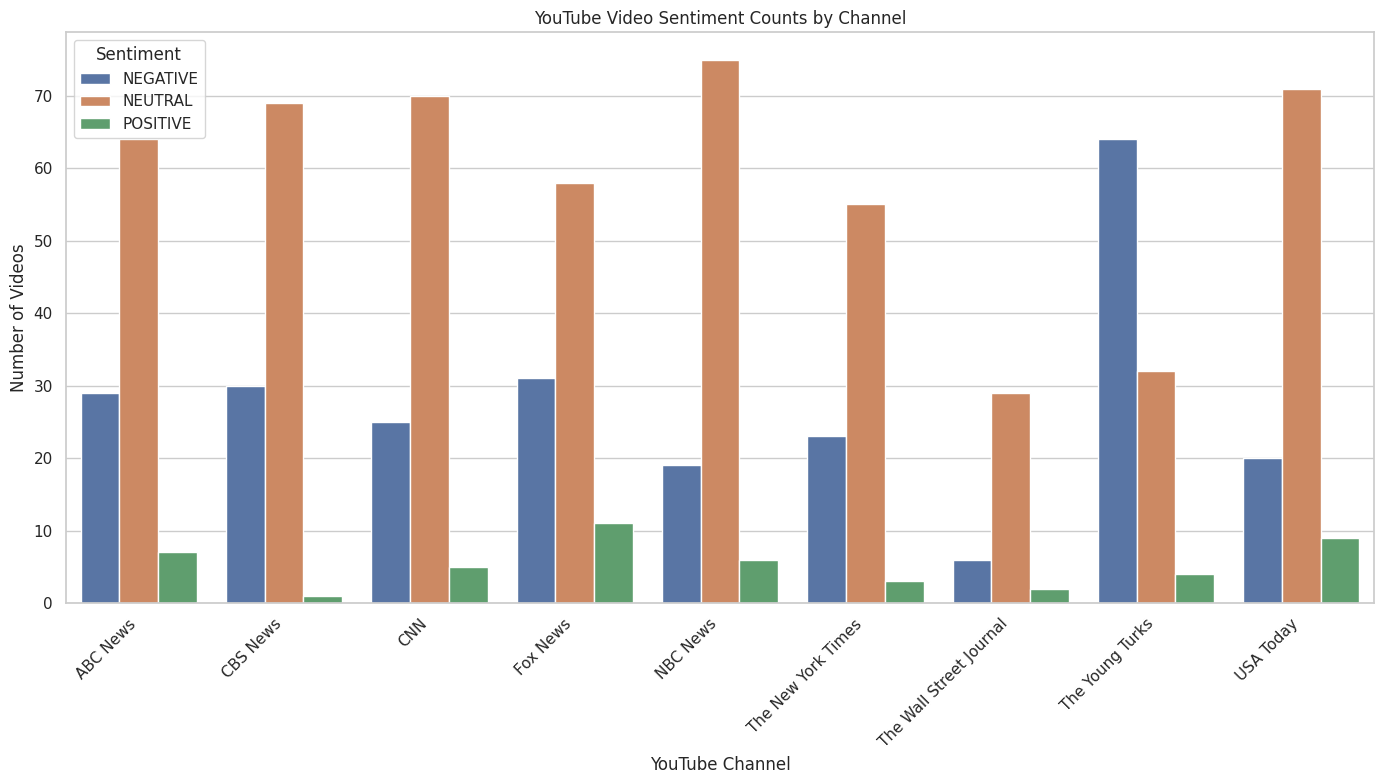

In [ ]:
# Count number of videos per sentiment per channel
channel_sentiment_counts = df.groupby(['Channel', 'sentiment']).size().reset_index(name='count')

# Set plot style
sns.set(style="whitegrid")

# Create a grouped barplot
plt.figure(figsize=(14, 8))
sns.barplot(
    data=channel_sentiment_counts,
    x='Channel',
    y='count',
    hue='sentiment'
)
plt.title('YouTube Video Sentiment Counts by Channel')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Videos')
plt.xlabel('YouTube Channel')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

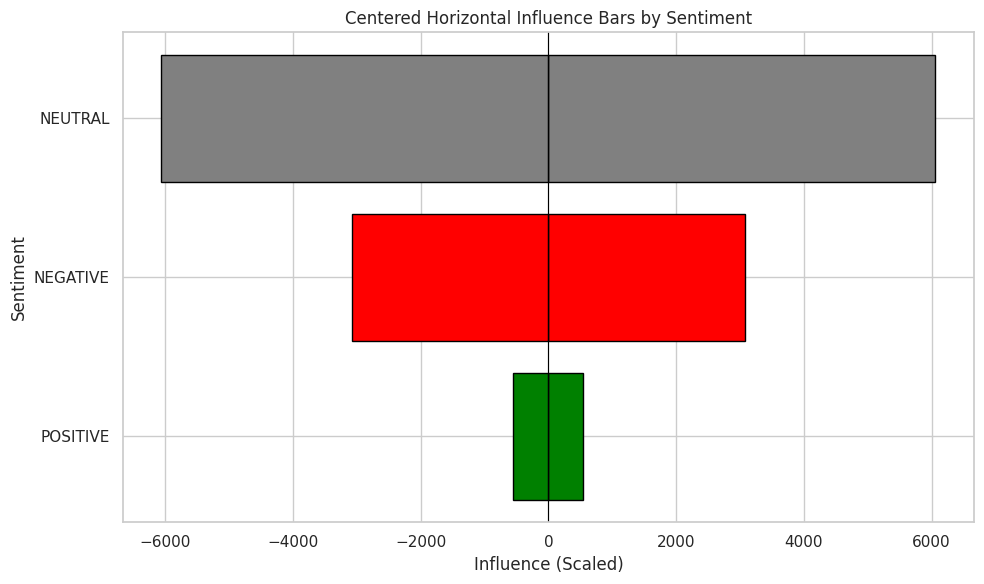

In [ ]:
# 1. Aggregate total influence per sentiment
sentiment_influence = (
    df.groupby("sentiment")["Influence_scaled"]
      .sum()
      .sort_values()   # ranked
)

# 2. Split into positive/negative halves for centered bars
half = sentiment_influence / 2
neg_half = -half
pos_half = half

# 3. Pick colors for each sentiment
colors = {
    "NEGATIVE": "red",
    "NEUTRAL": "gray",
    "POSITIVE": "green"
}

# 4. Plot centered ranked bars
plt.figure(figsize=(10,6))

for sentiment in sentiment_influence.index:
    plt.barh(
        sentiment,
        pos_half.loc[sentiment],
        color=colors.get(sentiment, "blue"),
        edgecolor="black"
    )
    plt.barh(
        sentiment,
        neg_half.loc[sentiment],
        color=colors.get(sentiment, "blue"),
        edgecolor="black"
    )

plt.axvline(0, color="black", linewidth=0.8)
plt.xlabel("Influence (Scaled)")
plt.ylabel("Sentiment")
plt.title("Centered Horizontal Influence Bars by Sentiment")

plt.tight_layout()
plt.show()

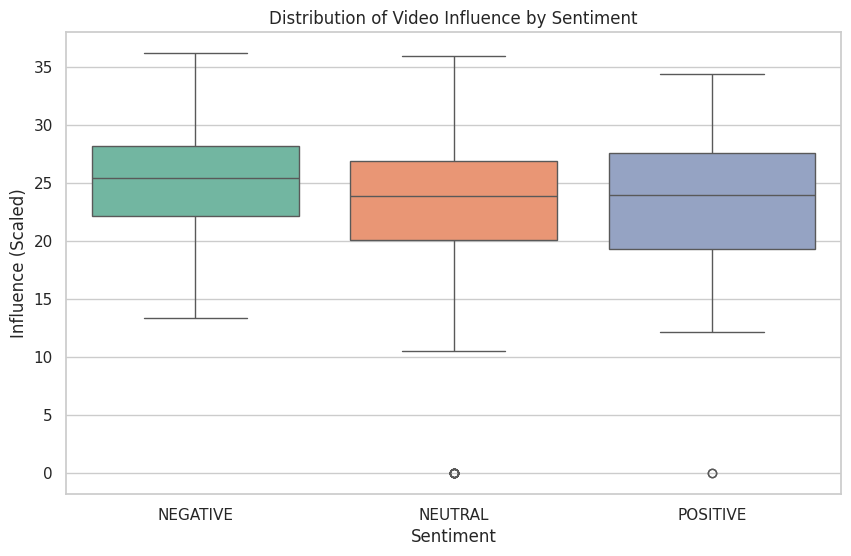

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.boxplot(
    data=df,
    x='sentiment',
    y='Influence_scaled',
    palette='Set2'
)

plt.title('Distribution of Video Influence by Sentiment')
plt.ylabel('Influence (Scaled)')
plt.xlabel('Sentiment')
plt.show()